This code is reproduction of the version 5 of "Dealing with the Inventory Risk" by Gueant, Lehalle and Tapia. 

Indeed the article is not trivial for a newcomer to the market making world, as well as for those who don't have a formal training in formal mathematics. In my case, since I'm far better at programming than in doing math (I actually decided to learn programming because of the article), I decided to reproduce the surfaces in the article after some long time of struggle. 

I didn't know any tutor or professional in this area to help me out, so the reproduction of the article was the only way I found to assert that my understanding is correct. The article's version used as reference here is found in https://arxiv.org/abs/1105.3115

This notebook is divided in two parts. The first one is a reproduction of the standard implementation, and the second one is the implementation of the solution with drift, where I believe there is an error.


<h1>Part 1: standard solution</h1>

The first plot to be reproduced is the one in page 8:

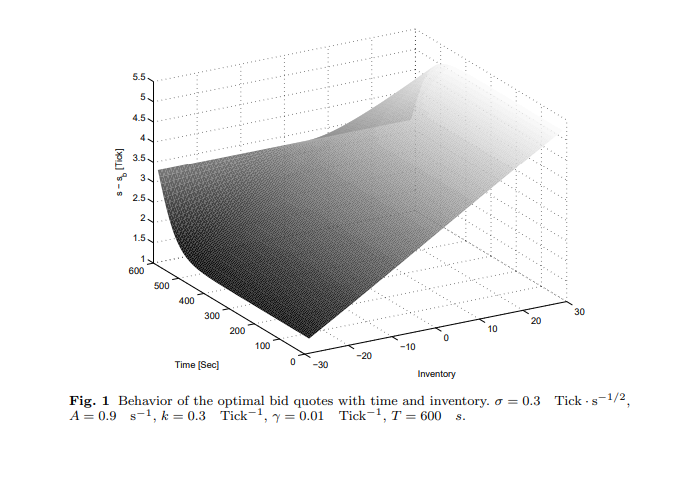

In [1]:
from IPython.display import Image
Image(filename='images/bid_surface.png',width=1000, height=600)

Now, proceeding to the imports and to the variable declarations. I'm using the same ones that can be found in the footnote of figure 1:

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.linalg import expm
import math


max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q

sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1

To get to the surface, one must implement the theorem 1.

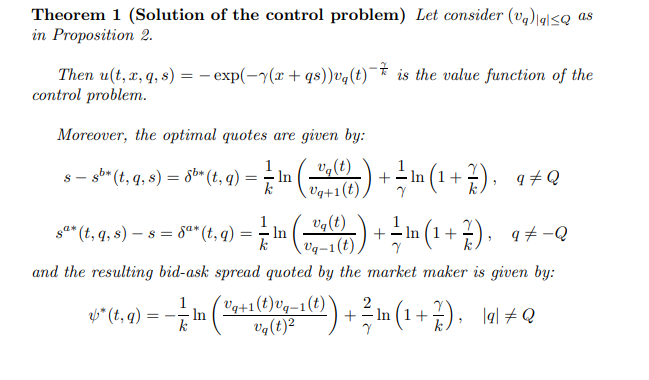

In [3]:
Image(filename='images/theorem_1.png',width=800, height=400)

And the "Value v of q at give time t" component can be obtained through proposition 2:

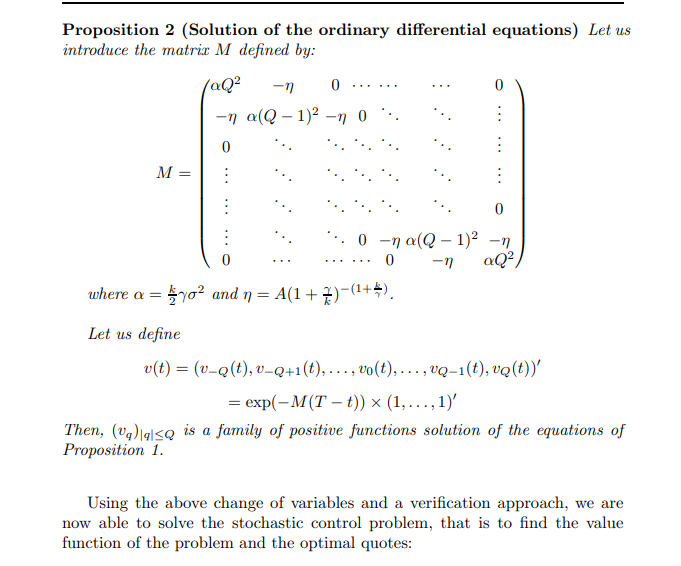

In [4]:
Image(filename='images/proposition_2.png',width=800, height=600)

So code wise, one must first implement matrix M, to then calculate the respective values functions of the portfolio with inventory q at time t.

First step is to construct a matrix with the elements. 

Iterations reference is about the size of the matrix; alpha and nill are very straight forward because one just needs to evaluate:

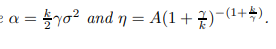

In [5]:
Image(filename='images/alpha_and_nill.png',width=800, height=400)

In [6]:
iterations_reference = 2 * max_inventory_Q + 1
## ALPHA, Nill
alpha = (kappa / 2) * gamma * sigma ** 2
nill  = A * (1 + gamma / kappa) ** ( - (1 + kappa / gamma) )

Constructing matrix M. To make it simpler, I'll first place the elements to the each row, to then stack the rows in the end to create a numpy matrix.

It's a bit tricky to see, but the "1" in "alpha * (Q - 1) ** 2" should be incremented as one offsets the rows.

In [7]:
matrix_M = []
first_row = []
last_row = []
list_middle_rows = []

for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

    # Populating first row
    if i == min_inventory_Q: 
        first_row.append(alpha * max_inventory_Q ** 2)
        first_row.append(-nill)
        first_row.extend([0 for j in range(iterations_reference - 2)])

    # Populating last row
    elif i == max_inventory_Q:
        last_row.extend([0 for j in range(iterations_reference - 2)])
        last_row.append(-nill)
        last_row.append(alpha * max_inventory_Q ** 2)

    # Populating middle rows
    else:
        middle_row = []
        if i < 0:
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i) ) ) ** 2, -nill])
            middle_row.extend([0 for j in range(iterations_reference - 3)])

            if i > -max_inventory_Q + 1:
                for j in range(0, max_inventory_Q + i - 1, 1):
                    middle_row.insert(0,middle_row.pop())

        if i == 0:
            middle_row = [0 for j in range(iterations_reference)]
            middle_row[max_inventory_Q + 1] = -nill
            middle_row[max_inventory_Q - 1] = -nill
            assert len(middle_row) == iterations_reference

        if i > 0:
            middle_row.extend([0 for j in range(iterations_reference - 3)])
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2, -nill])

            for j in range(0,  max_inventory_Q - i - 1, 1):
                middle_row.append(middle_row.pop(0))

        assert len(middle_row) == iterations_reference
        list_middle_rows.append(middle_row)

matrix_M.append(first_row)
matrix_M.extend(list_middle_rows)
matrix_M.append(last_row)

assert len(first_row) == iterations_reference
assert len(last_row) == iterations_reference

# Converting to numpy array
matrix_M = np.matrix(matrix_M)

pprint(matrix_M)

matrix([[ 0.1215    , -0.32567836,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.32567836,  0.113535  , -0.32567836, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.32567836,  0.10584   , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.10584   ,
         -0.32567836,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.32567836,
          0.113535  , -0.32567836],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.32567836,  0.1215    ]])


We have the matrix M, and we can calculate "v of q at time t" 

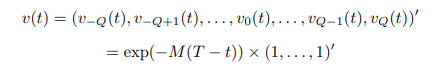

In [8]:
Image(filename='images/v_of_t.png',width=800, height=600)

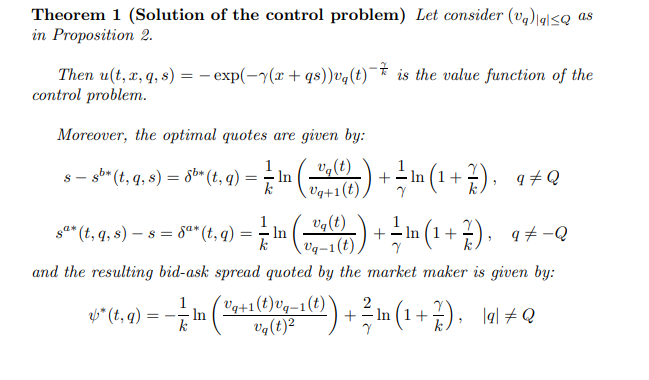

In [9]:
Image(filename='images/theorem_1.png',width=800, height=600)

Calculating the bid surface. One can also uncomment the ask code to get to the ask surface.

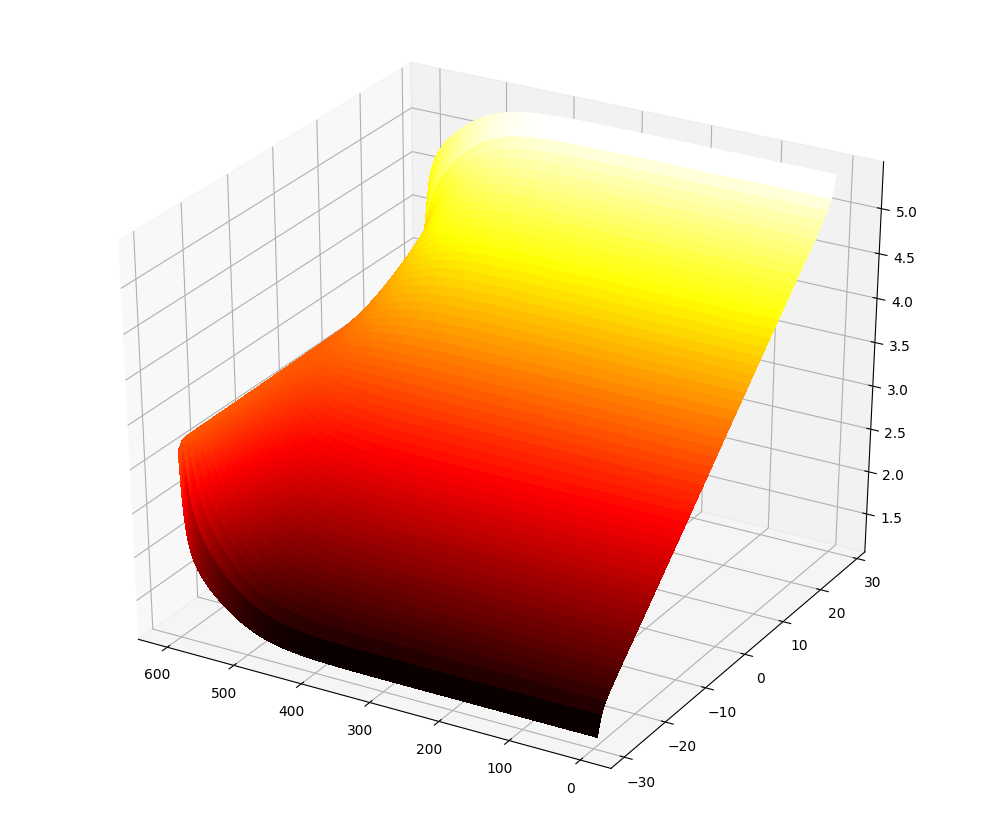

In [10]:
# to store the quotes at each time stap

list_evolution_bid = []
#list_evolution_ask = [] 


for t in range(0, T  , 1):
    
    dict_bid = {}
    # dict_ask = {}
    
    container = -matrix_M * (T - t)

    v_of_t = expm(container)
    v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

    # for each q in -Q .. Q apply the quotes theorem
    # variable "pseudo_q" is used because otherwise, the incorrect index of the v_of_t will be selected 
    # (negative q would go for the last element of v_of_t instead of the first one. 
    for pseudo_q in range(0, iterations_reference -1, 1):        
        q = pseudo_q - max_inventory_Q # real q
        
        bid = (1 / kappa) * np.log(v_of_t[pseudo_q] / v_of_t[pseudo_q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        #ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        
        # Storing in a dict
        dict_bid[q] = bid
        #dict_ask[q - max_inventory_Q] = ask

    # Bid quote at max_inventory (q = +Q) is inexistent, as such for ask quote at min_inventory (q = -Q)
    dict_bid[max_inventory_Q] = None
    #dict_ask[min_inventory_Q] = None

    list_evolution_bid.append(list(dict_bid.values())[1:-2])

# Plotting. Some rearrengements must be made to make the surface look just like in article
X = np.arange(1, T+1, 1)
Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
X, Y = np.meshgrid(X, Y)

Z = np.array(list_evolution_bid).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.invert_xaxis()

# Voilà! :)
fig.set_size_inches(12.5, 10.5, forward=True)
plt.show()

Plotting the image from the article once again so that we don't have to keep scrolling this notebook up and down to be able to make a comparisson.

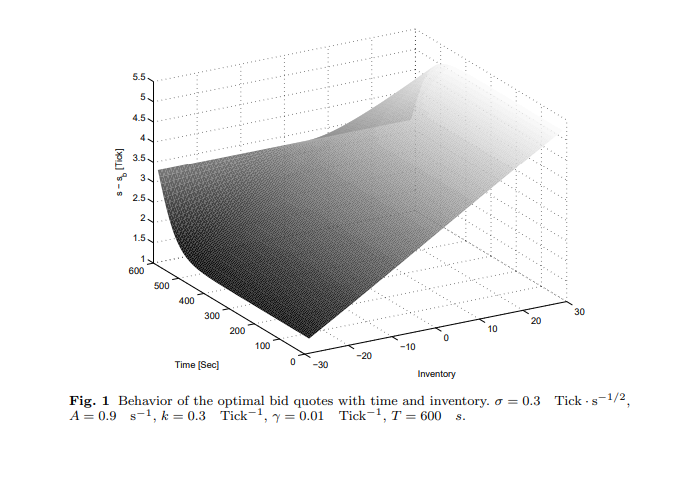

In [11]:
Image(filename='images/bid_surface.png',width=1000, height=600)

A sanity check: both surfaces have quote around 5.3 when q = +Q; bid is around 1.5 when q = -Q. Bid at t = 0 is at ~3.4, independently of q.

<h1>Part 2: solution with drift</h1>

There is another theorem in the article, it's a solution with a drift component u:

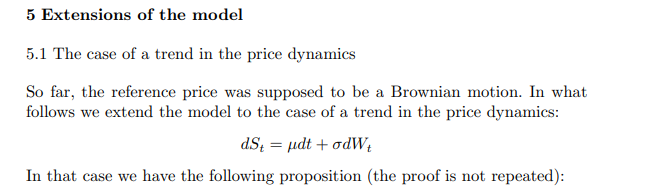

In [12]:
Image(filename='images/declaration_of_extension.png',width=1000, height=600)

My intuition is very simple regarding the drift term. If the market maker things that he price will go up, he should skew the quotes upwards, and the same thinking process for the opposite direction.

The first question is how should "u" be normalized? There are no nummerical simulations in this part of the article, so it took me a bit of time to figure out. In Fodra's and Labadie' paper https://arxiv.org/pdf/1206.4810.pdf on page 25:

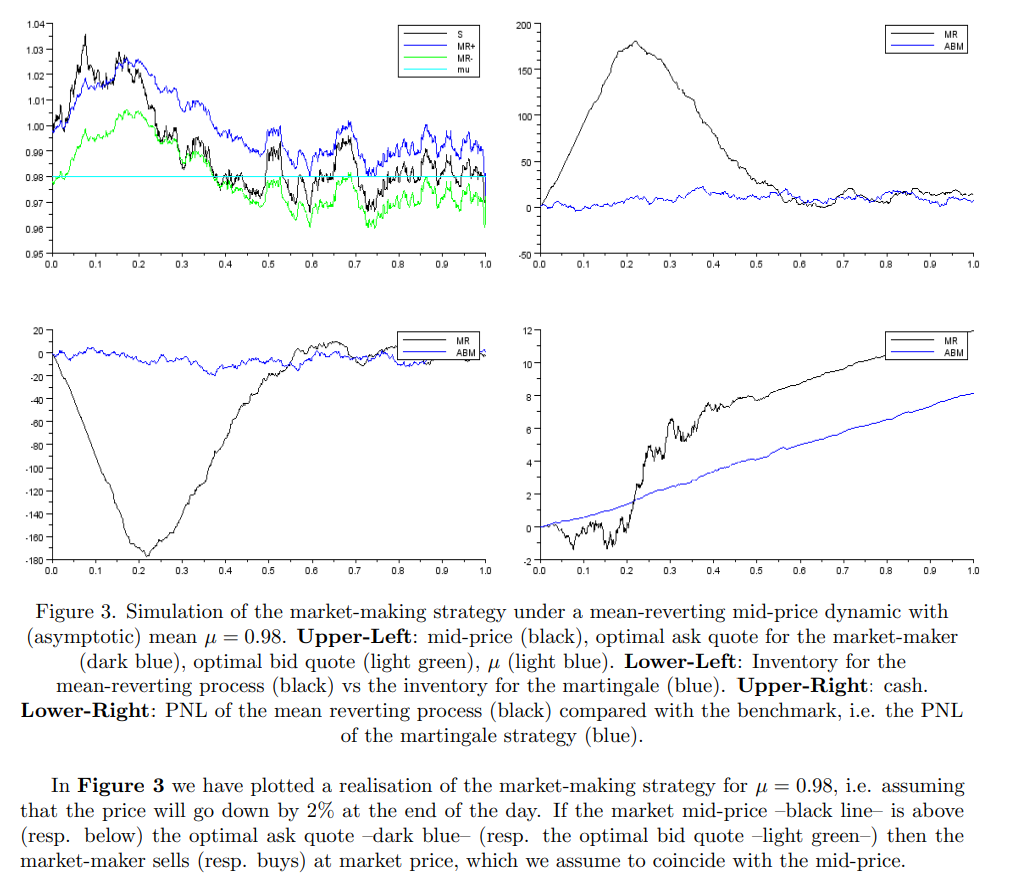

In [13]:
Image(filename='images/drift_definition.png',width=1000, height=600)

So it means that u should be positive and that if it is higher than 1, means that the market maker thinks that the market will go up, and if it is less than 1, that the market will go down.

Now going back to "Dealing with the inventory risk". The is a beta term in proposition 4 which encapsulates the drift term:

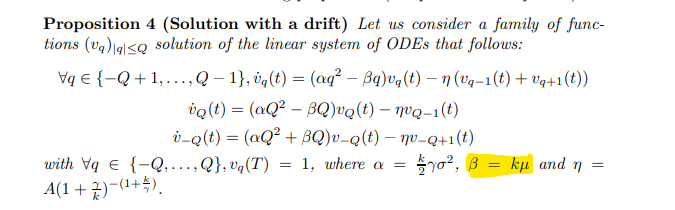

In [14]:
Image(filename='images/declaration_of_beta.png',width=1000, height=600)

And the beta term is added to the matrix M:

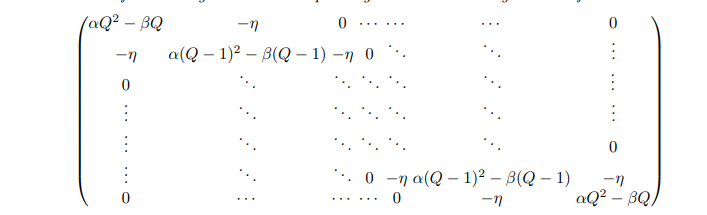

In [15]:
Image(filename='images/matrix_m_with_beta.png',width=1000, height=600)

Let's implement as in the paper and recalculate the bid surface if the u = 1, the simplest case:

/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/home/rafaelichow/miniconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: Ru

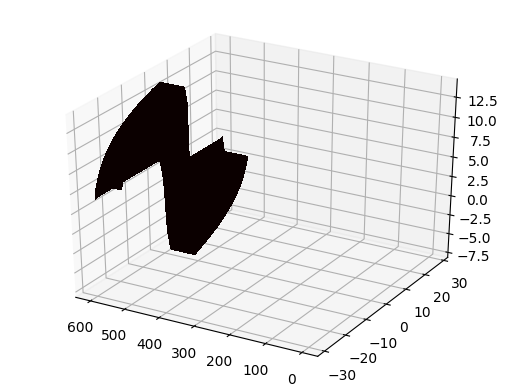

In [16]:

## BASIC VARIABLES
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q
iterations_reference = 2 * max_inventory_Q + 1
sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1
u = 1.0

## ALPHA, Nill
alpha = kappa / 2 * gamma * (sigma ** 2)
beta = kappa * u
nill  = A * (1 + gamma / kappa) ** - (1 + kappa / gamma)


matrix_M = []
first_row = []
last_row = []
list_middle_rows = []

for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

    # Populating first row
    if i == min_inventory_Q: 
        first_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)
        first_row.append(-nill)
        first_row.extend([0 for j in range(iterations_reference - 2)])

    # Populating last row
    elif i == max_inventory_Q:
        last_row.extend([0 for j in range(iterations_reference - 2)])
        last_row.append(-nill)
        last_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)

    # Populating middle rows
    else:
        middle_row = []
        if i < 0:
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])
            middle_row.extend([0 for j in range(iterations_reference - 3)])

            if i > -max_inventory_Q + 1:
                for j in range(0, max_inventory_Q + i - 1, 1):
                    middle_row.insert(0,middle_row.pop())

        if i == 0:
            middle_row = [0 for j in range(iterations_reference)]
            middle_row[max_inventory_Q + 1] = -nill
            middle_row[max_inventory_Q - 1] = -nill
            assert len(middle_row) == iterations_reference

        if i > 0:
            middle_row.extend([0 for j in range(iterations_reference - 3)])
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])

            for j in range(0,  max_inventory_Q - i - 1, 1):
                middle_row.append(middle_row.pop(0))

        assert len(middle_row) == iterations_reference
        list_middle_rows.append(middle_row)

matrix_M.append(first_row)
matrix_M.extend(list_middle_rows)
matrix_M.append(last_row)

assert len(first_row) == iterations_reference
assert len(last_row) == iterations_reference

# Converting to numpy array
matrix_M = np.matrix(matrix_M)

# Simulating negative inventory
list_evolution_bid = []
list_evolution_ask = []
for t in range(0, T  , 1):
    dict_bid = {}
    dict_ask = {}
    list_bid_at_t = []
    container = -matrix_M * (T - t)

    v_of_t = expm(container)
    v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

    for q in range(0, iterations_reference -1, 1):
        bid = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        dict_ask[q - max_inventory_Q] = ask
        dict_bid[q - max_inventory_Q] = bid

    dict_bid[max_inventory_Q] = None
    dict_ask[min_inventory_Q] = None
    dict_ask[max_inventory_Q] = dict_bid[min_inventory_Q]

    list_evolution_bid.append(list(dict_bid.values())[1:-2])

# Plotting 
X = np.arange(1, T+1, 1)
Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
X, Y = np.meshgrid(X, Y)

Z = np.array(list_evolution_bid).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.invert_xaxis()

plt.show()

The plot makes no sense. However, if I force change "beta = k * u" to "beta = -k * u", thus making beta positive in the matrix, the we have this:

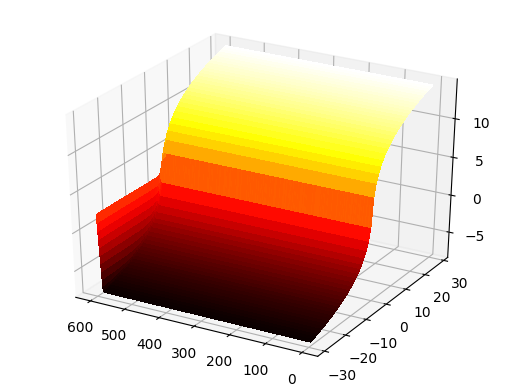

In [31]:

## BASIC VARIABLES
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q
iterations_reference = 2 * max_inventory_Q + 1
sigma = 0.3
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600
dt = 1


def make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u):
    ## ALPHA, Nill
    alpha = kappa / 2 * gamma * (sigma ** 2)
    beta = -kappa * u
    nill  = A * (1 + gamma / kappa) ** - (1 + kappa / gamma)


    matrix_M = []
    first_row = []
    last_row = []
    list_middle_rows = []

    for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

        # Populating first row
        if i == min_inventory_Q: 
            first_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)
            first_row.append(-nill)
            first_row.extend([0 for j in range(iterations_reference - 2)])

        # Populating last row
        elif i == max_inventory_Q:
            last_row.extend([0 for j in range(iterations_reference - 2)])
            last_row.append(-nill)
            last_row.append(alpha * max_inventory_Q ** 2 - beta * max_inventory_Q)

        # Populating middle rows
        else:
            middle_row = []
            if i < 0:
                middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])
                middle_row.extend([0 for j in range(iterations_reference - 3)])

                if i > -max_inventory_Q + 1:
                    for j in range(0, max_inventory_Q + i - 1, 1):
                        middle_row.insert(0,middle_row.pop())

            if i == 0:
                middle_row = [0 for j in range(iterations_reference)]
                middle_row[max_inventory_Q + 1] = -nill
                middle_row[max_inventory_Q - 1] = -nill
                assert len(middle_row) == iterations_reference

            if i > 0:
                middle_row.extend([0 for j in range(iterations_reference - 3)])
                middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2 - beta * ( max_inventory_Q - (max_inventory_Q - abs(i)) ), -nill])

                for j in range(0,  max_inventory_Q - i - 1, 1):
                    middle_row.append(middle_row.pop(0))

            assert len(middle_row) == iterations_reference
            list_middle_rows.append(middle_row)

    matrix_M.append(first_row)
    matrix_M.extend(list_middle_rows)
    matrix_M.append(last_row)

    assert len(first_row) == iterations_reference
    assert len(last_row) == iterations_reference

    # Converting to numpy array
    matrix_M = np.matrix(matrix_M)

    # Simulating negative inventory
    list_evolution_bid = []
    list_evolution_ask = []
    for t in range(0, T  , 1):
        dict_bid = {}
        dict_ask = {}
        list_bid_at_t = []
        container = -matrix_M * (T - t)

        v_of_t = expm(container)
        v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

        for q in range(0, iterations_reference -1, 1):
            bid = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
            ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
            dict_ask[q - max_inventory_Q] = ask
            dict_bid[q - max_inventory_Q] = bid

        dict_bid[max_inventory_Q] = None
        dict_ask[min_inventory_Q] = None
        dict_ask[max_inventory_Q] = dict_bid[min_inventory_Q]

        list_evolution_bid.append(list(dict_bid.values())[1:-2])

    # Plotting 
    X = np.arange(1, T+1, 1)
    Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
    X, Y = np.meshgrid(X, Y)

    Z = np.array(list_evolution_bid).T

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
    ax.invert_xaxis()

    plt.show()
    
u = 1.05
make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u)

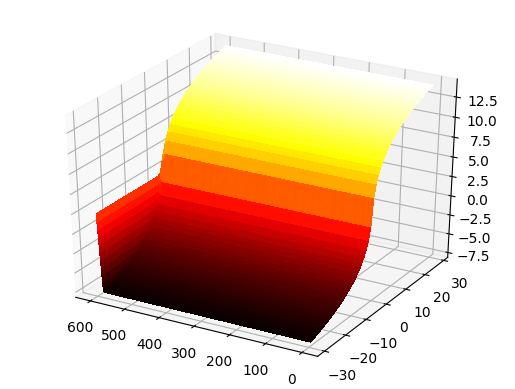

In [33]:
u = 0.95
make_plot(min_inventory_Q, max_inventory_Q, iterations_reference, sigma, A, kappa, gamma, T, dt, u)

which is more aligned with the standard solution, though these are some points:

 - In the case where u = 1.05 under assymptotic behaviour, looking at q = -30, we have bid ~= -5, meaning we are sending market orders. It most probably makes sense to send market orders on the bid side, after all the price is expected to go up.
 - in the case where u = 0.95 under assymptotic behaviour, looking at q = -30, we have bid ~= -7.5 meaning we are placing "more intense" market orders. The price is expected to go down and the we are sending market orders on the bid side when our inventory is very negative. However, I was expecting for the bid quote to be higher than the one from the standard solution (here we have -7.5 and in the stardard solution is ~1.5) and I don't have an answer for this phenomenon.
 
 <h2>Possible explanation of why matrix M is wrong in the solution with drift</h2>
 
As I described in the beginning of the article, I have no formal training in mathematics (I just have a bachelor in business) so even though I can demonstrate that the beta sign is most probably wrong with code/numerical simulations, I'm not competent to prove it via deductive mathematics.

For a long time, I was't able to encounter people that were able to discuss market making to a deeper level, however I was lucky to find after some years, even though on github only.

I raised the question regarding the matrix M being probably wrong on https://github.com/nkaz001/hftbacktest/issues/21 and I was given this answer:

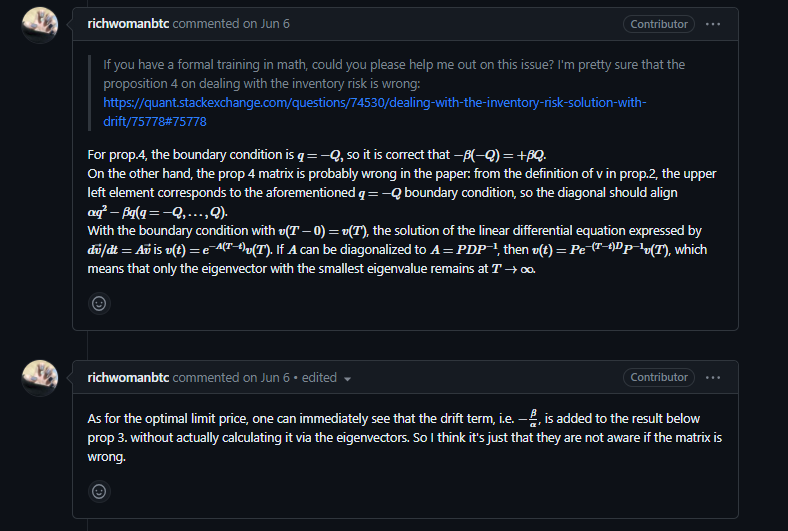

In [19]:
Image(filename='images/explanation_matrix_with_drift.png',width=1000, height=600)

<h1>Part 3: discussion about figure 4</h1>

In the paper we have figure 4:


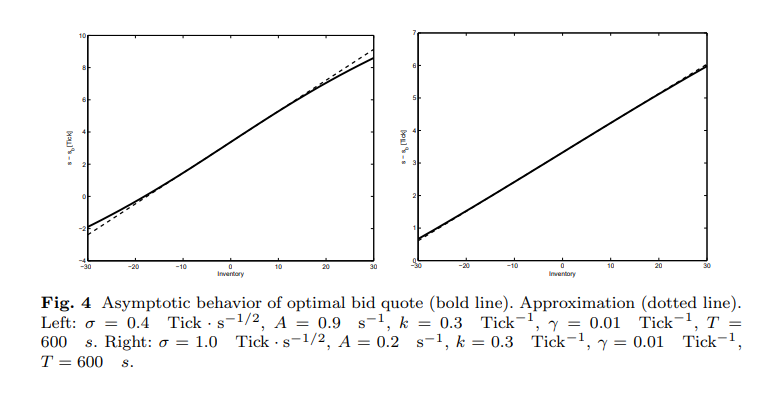

In [20]:
Image(filename='images/figure_4.png',width=1000, height=600)

matrix([[ 0.216     , -0.32567836,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.32567836,  0.20184   , -0.32567836, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.32567836,  0.18816   , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.18816   ,
         -0.32567836,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.32567836,
          0.20184   , -0.32567836],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.32567836,  0.216     ]])


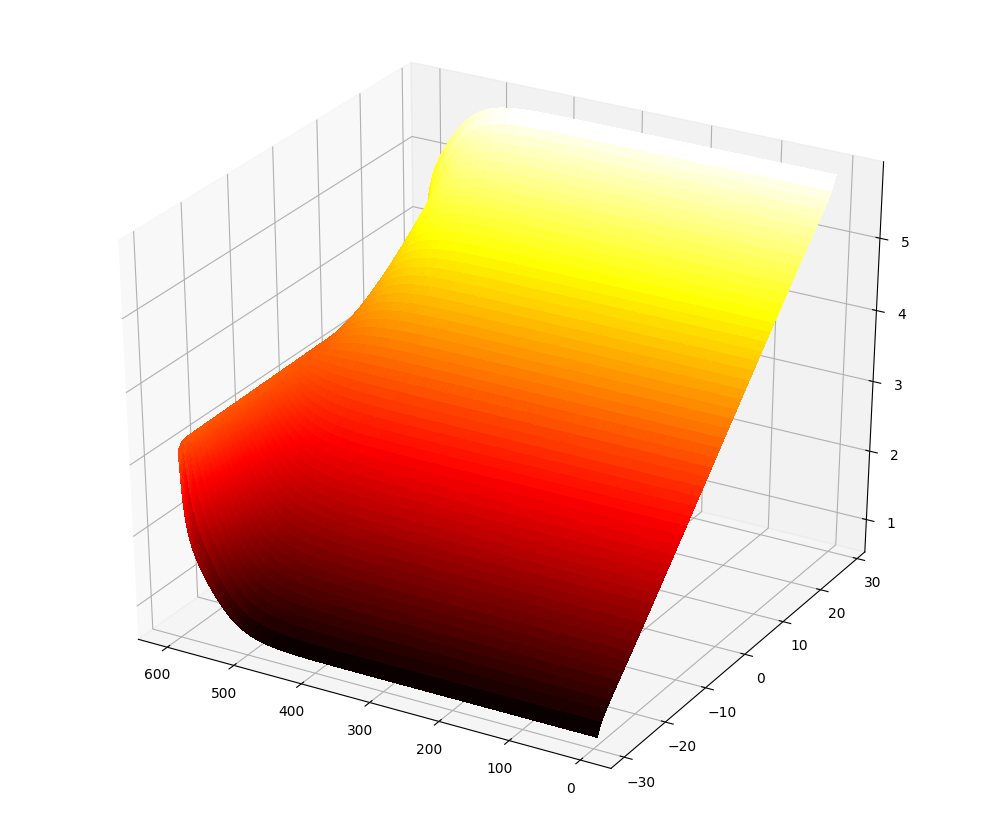

In [21]:
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q

sigma = 0.4 # note that sigma changed from the previous implementation! It was 0.3 and now is 0.4
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1


iterations_reference = 2 * max_inventory_Q + 1
## ALPHA, Nill
alpha = (kappa / 2) * gamma * sigma ** 2
nill  = A * (1 + gamma / kappa) ** ( - (1 + kappa / gamma) )


matrix_M = []
first_row = []
last_row = []
list_middle_rows = []

for i in range(min_inventory_Q, max_inventory_Q + 1, 1):

    # Populating first row
    if i == min_inventory_Q: 
        first_row.append(alpha * max_inventory_Q ** 2)
        first_row.append(-nill)
        first_row.extend([0 for j in range(iterations_reference - 2)])

    # Populating last row
    elif i == max_inventory_Q:
        last_row.extend([0 for j in range(iterations_reference - 2)])
        last_row.append(-nill)
        last_row.append(alpha * max_inventory_Q ** 2)

    # Populating middle rows
    else:
        middle_row = []
        if i < 0:
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i) ) ) ** 2, -nill])
            middle_row.extend([0 for j in range(iterations_reference - 3)])

            if i > -max_inventory_Q + 1:
                for j in range(0, max_inventory_Q + i - 1, 1):
                    middle_row.insert(0,middle_row.pop())

        if i == 0:
            middle_row = [0 for j in range(iterations_reference)]
            middle_row[max_inventory_Q + 1] = -nill
            middle_row[max_inventory_Q - 1] = -nill
            assert len(middle_row) == iterations_reference

        if i > 0:
            middle_row.extend([0 for j in range(iterations_reference - 3)])
            middle_row.extend([-nill, alpha * ( max_inventory_Q - (max_inventory_Q - abs(i)) ) ** 2, -nill])

            for j in range(0,  max_inventory_Q - i - 1, 1):
                middle_row.append(middle_row.pop(0))

        assert len(middle_row) == iterations_reference
        list_middle_rows.append(middle_row)

matrix_M.append(first_row)
matrix_M.extend(list_middle_rows)
matrix_M.append(last_row)

assert len(first_row) == iterations_reference
assert len(last_row) == iterations_reference

# Converting to numpy array
matrix_M = np.matrix(matrix_M)

pprint(matrix_M)

list_evolution_bid = []
#list_evolution_ask = [] 

for t in range(0, T  , 1):
    
    dict_bid = {}
    # dict_ask = {}
    
    container = -matrix_M * (T - t)

    v_of_t = expm(container)
    v_of_t  = np.sum(np.multiply(v_of_t, np.ones(v_of_t.shape[0])), axis=1)

    # for each q in -Q .. Q apply the quotes theorem
    # variable "pseudo_q" is used because otherwise, the incorrect index of the v_of_t will be selected 
    # (negative q would go for the last element of v_of_t instead of the first one. 
    for pseudo_q in range(0, iterations_reference -1, 1):        
        q = pseudo_q - max_inventory_Q # real q
        
        bid = (1 / kappa) * np.log(v_of_t[pseudo_q] / v_of_t[pseudo_q + 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        #ask = (1 / kappa) * np.log(v_of_t[q] / v_of_t[q - 1]) + (1 / gamma) * np.log(1 + gamma / kappa)
        
        # Storing in a dict
        dict_bid[q] = bid
        #dict_ask[q - max_inventory_Q] = ask

    # Bid quote at max_inventory (q = +Q) is inexistent, as such for ask quote at min_inventory (q = -Q)
    dict_bid[max_inventory_Q] = None
    #dict_ask[min_inventory_Q] = None

    list_evolution_bid.append(list(dict_bid.values())[1:-2])

# Plotting. Some rearrengements must be made to make the surface look just like in article
X = np.arange(1, T+1, 1)
Y = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
X, Y = np.meshgrid(X, Y)

Z = np.array(list_evolution_bid).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.invert_xaxis()

# Voilà! :)
fig.set_size_inches(12.5, 10.5, forward=True)
plt.show()

In the terminal time and at q = -30, the plot seems to be bent downwards and not upwards as in the article.



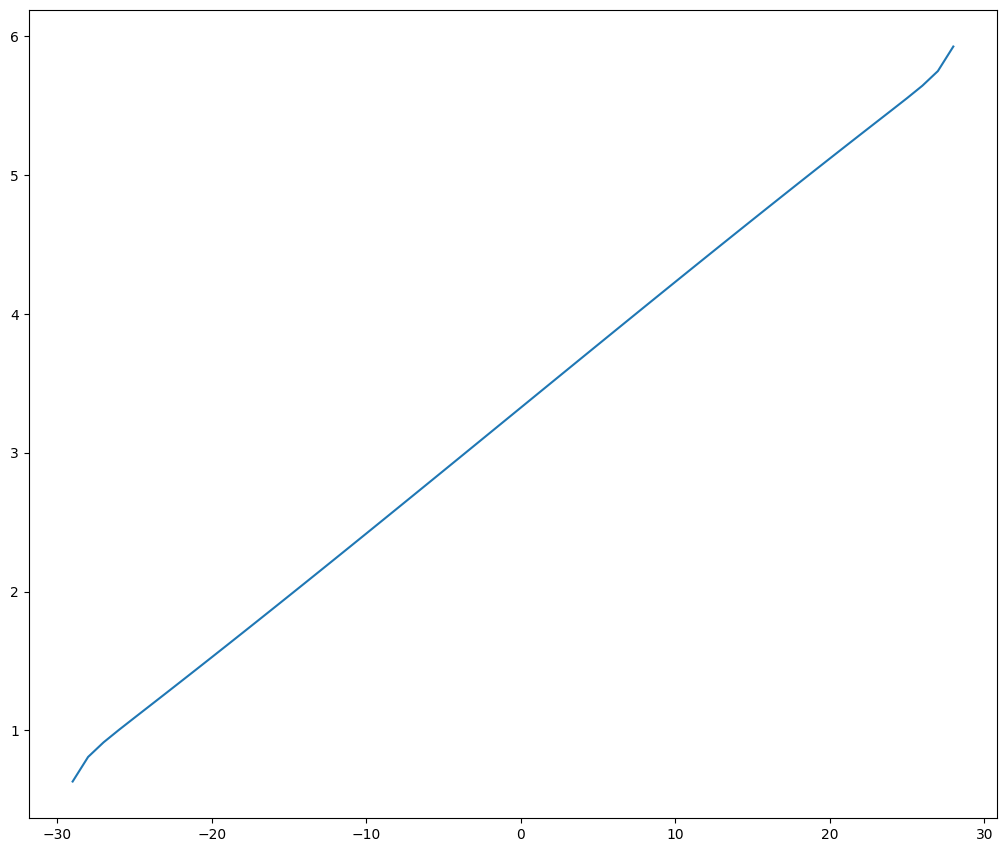

In [22]:
# Plotting. Some rearrengements must be made to make the surface look just like in article
#X = np.arange(1, T+1, 1)
X = np.arange(min_inventory_Q+1, max_inventory_Q-1 , 1)
#X, Y = np.meshgrid(X, Y)

Y = np.array(list_evolution_bid[0])

fig = plt.figure()
ax = fig.add_subplot(111)

#surf = ax.plot(X, Y, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
ax.plot(X, Y)

#ax.invert_xaxis()

#print(list_evolution_bid[0])
fig.set_size_inches(12.5, 10.5, forward=True)
#plt.show()

After thinking for a while, I concluded the following: the δb is the value that needs to be subtracted from the reference price. If δb = 2, tick size = 1 and mid price is 100, means that bid must be placed at 98. When inventory is very negative, the market maker becomes more inventory averse, so he has to bid higher to increase chances of buying. To bid higher, δb must be more negative. δb=-3 is more aggressive than δb =-1, because 100 - (-3) > 100 - (-1) and resulting bid will be at 103 instead than at 101. The point is, shouldn't the asymtotic figure's be extremes be "inverted" this other way?  

I'll reimplement the assymptotic approximation for effect of comparisson:

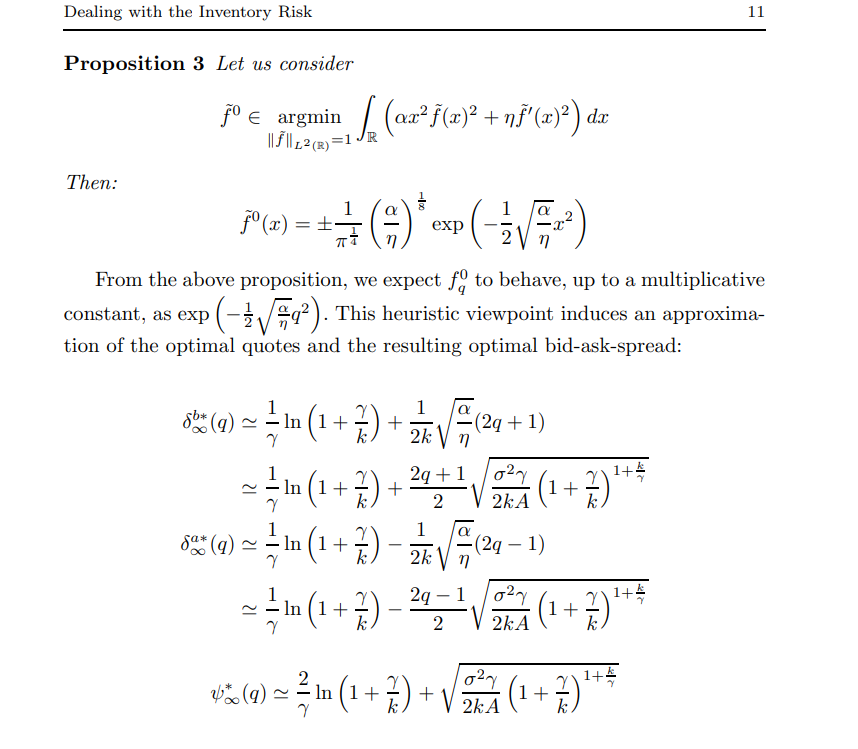

In [23]:
Image(filename='images/proposition_3.png',width=1000, height=600)

Implementing the bid approximations using the first method and using the same parameters as in the left plot of figure 4, which has more exacerbated quotes:

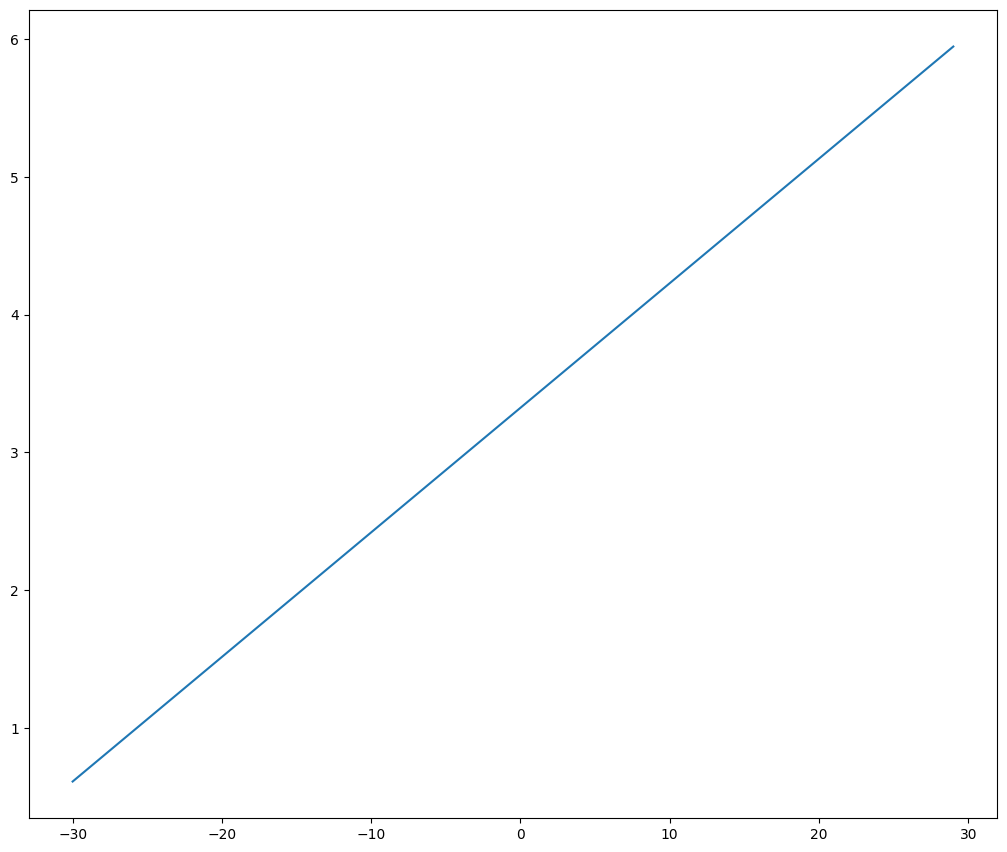

In [24]:
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q

sigma = 0.4 # note that sigma changed from the previous implementation! It was 0.3 and now is 0.4
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1

list_bid = []
for q in range(min_inventory_Q, max_inventory_Q , 1):
    alpha = kappa / 2 * gamma * sigma ** 2
    nill  = A * (1 + gamma / kappa) ** - (1 + kappa / gamma)
    bid = 1/ gamma * np.log(1 + gamma / kappa) + 1 / (2 * kappa) * math.sqrt(alpha / nill) * (2 * q + 1)
    
    #print(q, bid)
    list_bid.append(bid)

X = np.arange(min_inventory_Q, max_inventory_Q , 1)

Y = np.array(list_bid)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X, Y)

fig.set_size_inches(12.5, 10.5, forward=True)


And with the second method:

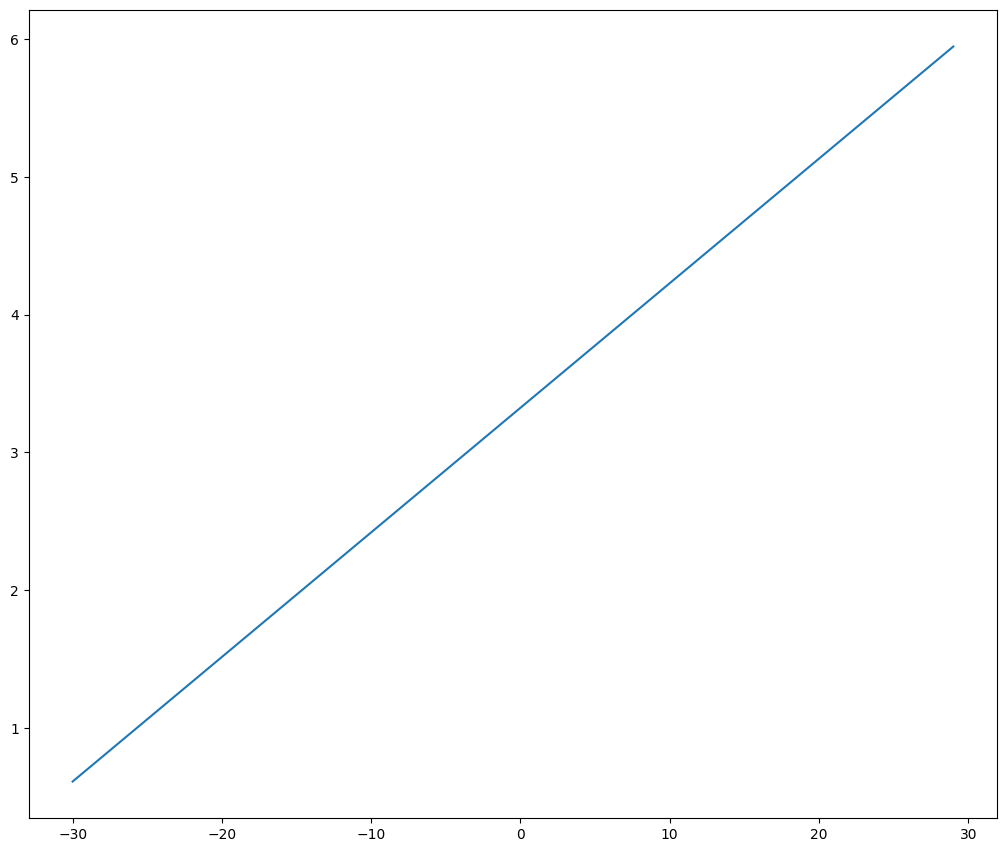

In [25]:
max_inventory_Q = 30
min_inventory_Q = -max_inventory_Q

sigma = 0.4 # note that sigma changed from the previous implementation! It was 0.3 and now is 0.4
A = 0.9
kappa = 0.3
gamma =  0.01
T = 600 # Terminal Time
dt = 1

list_bid = []
for q in range(min_inventory_Q, max_inventory_Q , 1):
    bid =  (1 / gamma) * np.log(1 + gamma / kappa) + (2 * q + 1) / 2  * \
        math.sqrt( (sigma ** 2 * gamma) / (2 * kappa * A)  * ( 1 + gamma / kappa) ** (1  + kappa / gamma) )
    list_bid.append(bid)

X = np.arange(min_inventory_Q, max_inventory_Q , 1)

Y = np.array(list_bid)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X, Y)

fig.set_size_inches(12.5, 10.5, forward=True)